# Assignment 1 (Part 2)
** COMP9418 - Advanced Topics in Statistical Machine Learning **

** Instructor: Edwin V. Bonilla **

** Last update: August 23rd at 10:35pm **

## General Instructions
In this practical part of the assignment you will build a class-conditional classifer using Gaussian Mixture Models (GMMs). 

1. For all the machine-learning related code you have two options: (a) use [scikit-learn](http://scikit-learn.org/stable/) and/or (b) write your own code. In particular, for fitting GMMs or building the classifier, you should refrain from using other packages. 
2. You can use the same GMM package that we used in the corresponding tutorial on GMMs, i.e. [scikit-learn Gaussian Mixture](http://scikit-learn.org/stable/modules/mixture.html). You should use standard (non-variational) Expectation-Maximisation updates  for parameter estimation. 
3. Do not delete any of the existing code in this notebook as we will use it to assess the performance of your algorithm.

### Main task
Your tasks is to build a class-conditional classifier for classifying digits using the MNIST dataset. You are given a file `mnist_train.npz` that contains images of digits (0-9). 
- The features `xtrain`, which have been normalized to be between [0,1], are 784 dimensional vectors corresponding to 28 * 28 image intensities. 
- The targets `ytrain` contain the class label of each example using one-hot-encoding. 
- In total there are 60,000 examples, each with one label from the 10 different classes. 
- The original dataset can be found at http://yann.lecun.com/exdb/mnist/ and you can read more about this dataset there. However, this dataset has been processed and shuffled so the training and test data in this exercise do not correspond to the original sets. 
- Note that you are only provided with training data `xtrain`, `ytrain`. In order to learn and test you model, you may consider splitting these data into training, validation and testing.   In particular, if you want to assess the performance of your model in section 2, you must create a test set `mnist_test.npz`. You are not required to submit this test file as we will evaluate the performance of your model using our own test data.


### Refresher
Recall that a class-conditional classifier models the joint distribution of features $\mathbf{x}$ and classes $y$ as $p(\mathbf{x}, y) = p(y) p(\mathbf{x} | y)$ and then uses Bayes' rule $p(y | \mathbf{x}) \propto  p(y) p(\mathbf{x} | y)$ to make predictions. In this assignment, you will use a GMM for each of the conditional densities $p(\mathbf{x} | y)$ and a Categorical distribution for $p(y)$.   

### Assessment
Your work will be assessed based on:
- [50%] the application of the concepts for doing model selection, which allows you to learn a single model for prediction (Section 1);  
- [30%] the code you write for making predicitions in your model (Section 2); and
- [20%] the predictive performance of your model (Section 3). 

### Packages 
Add required libraries here.

In [1]:
# Necessary libraries
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# Put the graphs where we can see them
%matplotlib inline

You can use the function below to plot a digit in the dataset.

In [3]:
def plot_image(array, dim=28):
    """
    Plot array as an image of dimensions dim * dim
    """
    img = array.reshape(dim,dim, order = "C")
    pl.imshow(img, cmap=pl.cm.gray)
    ax = pl.gca();ax.set_yticks([]);ax.set_xticks([])

This is how you should load your training data.

In [4]:
data = np.load('mnist_train.npz')

# training data
xtrain = data['xtrain']
ytrain = data['ytrain']

Here and example of plotting a specific digit and showing its corresponding label.

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


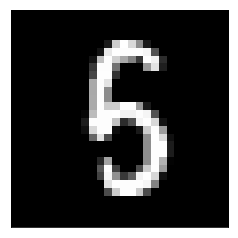

In [5]:
idx = 10
plot_image(xtrain[idx,:])
print ytrain[idx,:]

## 1. [50%] Training the model

Place all the code for training your model using the function `train_model` below. 

- We should be able to run your notebook (by clicking 'Cell->Run All') without errors. However, you must save the trained model in the file `model.npz`. This file will be loaded to make predictions in section 2 and assess the performance of your model in section 3. Note that, in addition to this notebook file, <span style="color:red"> ** you must provide the file model.npz **</span>.

- You should comment your code as much as possible so we understand your reasoning about training, model selection and avoiding overfitting. 

- You can process the data as you wish, e.g. by applying some additonal transformations, reducing dimensionality, etc. However, all these should be here too. 
- Wrap all your training using the function `train_model` below. You can call all other custom functions within it.

- I strongly discourage you from using a full covariance for each of the components of your Gaussian mixture, as the number of parameters grows quadratically on the dimensionality of the data and you will be unable to fit the file size cap in your submission (besides running into various numerical issues). 

In [6]:
def train_model(xtrain, ytrain):
    """
    Write your code here.
    """
    # reduce train set to 20 dimensions with pca
    pca = PCA(n_components=20)
    pca.fit(xtrain)
    xtrain_fix = pca.transform(xtrain)
    
    # change ytrain from one-hot type to Numeric, they will helpfull in next step
    ytrain_fix = np.zeros(ytrain.shape[0])
    for i,x in enumerate(ytrain):
        n=0
        while n<10:
            if ytrain[i,n]==1:
                ytrain_fix[i]=n
                break
            n+=1
            
    # save class label and number of samples in each
    subtrain = []
    length = []
    for i in range(10):
        subtrain.append((ytrain_fix==i).ravel())
        length.append(xtrain_fix[subtrain[i]].shape[0])
        
    # create the model set, using 10*10 models with 10 for each class
    gmm = []
    for i in range(10):
        subgmms=[]
        for j in range(10):
            subgmm = mixture.GaussianMixture(
                        n_components=j+1,
                covariance_type='full')
            subgmm.fit(xtrain_fix[subtrain[i], :])
            subgmms.append(subgmm)
        gmm.append(subgmms)
    #save gmms and pca to model
    model = []
    model.append(gmm)
    model.append(pca)
    model.append(length)
    # You can modify this to save other variables, etc 
    # but make sure the name of the file is 'model.npz.
    np.savez_compressed(
        'model.npz',
        model=model,
    )

## 2. [30%] Predictions

Here we will assume that there is a file `mnist_test.npz` from which we will load the test data.  As this file is not given to you, you will need to create one yourself (but not to submit it) to test your code. <span style="color:red">Note that if you do not create this file the cell below will not run</span>. 

Your task is to fill in the `make_predictions` function below. Note that this function should load your `model.npz` file, which must contain all the data structures necessary for making predictions.


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


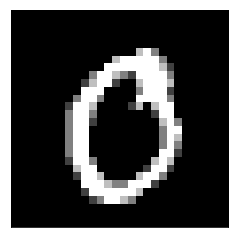

In [7]:
test = np.load('mnist_test.npz')
# test data
xtest = test['xtest']
ytest = test['ytest']
idx = 1000
plot_image(xtest[idx,:])
print ytest[idx,:]

In [12]:
def make_predictions(xtest):
    """
    @param xtest: (Ntest,D)-array with test data
    @return class_pred: (N,C)-array with predicted classes using one-hot-encoding 
    @return class_logprob: (N,C)-array with  predicted log probability of the classes   
    """

    # Add your code here: You should load your trained model here 
    # and write to the corresponding code for making predictions
    model = np.load('model.npz')['model'].tolist()
    gmm = model[0]
    pca = model[1]
    length = model[2]
    # change to 20 dimensions
    xtest_fix = pca.transform(xtest)
    pred = np.zeros([xtest.shape[0]],dtype = int)
    #save log p(x|y)
    loglike = np.zeros([10,xtest.shape[0]])
    class_logprob = np.zeros([xtest.shape[0],10])
    #using score_samples to get log likelihood of each gmm
    for i in range(10):
        temp=np.zeros([10,xtest.shape[0]])
        for j in range(10):
            temp[j]= gmm[i][j].score_samples(xtest_fix)
        loglike[i] = np.amax(temp,axis = 0)
    #calculate log (p(y|x)∝ p(y)p(x|y)) and make prediction
    for i in range(xtest.shape[0]):
        pre = 0
        maxprob = -999999999
        
        for j in range(10):
            logpyx = np.log((length[j]+.0)/60000) + loglike[j,i]
            class_logprob[i,j] = logpyx
            
            if logpyx>=maxprob:
                maxprob = logpyx
                pre = j
        pred[i] = pre
        
    #change prediction to one-hot
    class_pred = np.eye(10)[pred]    

    
    return class_pred, class_logprob

## 3. [20%] Performance 
You do not need to do anything in this section but you can use it to test the generalisation performance of your code. We will use it the evaluate the performance of your algorithm on a new test test. 

In [9]:
def predictive_performance(xdata, ydata, class_pred, class_logprob):
    """
    @param xdata:  (N,D)-array of features 
    @param ydata:  (N,C)-array of one-hot-encoded true classes
    @class_pred: (N,C)-array of one-hot-encoded predicted classes
    @class_logprob: (N,C)-array of predicted class log probabilities 
    """
    correct = np.zeros(xdata.shape[0])
    ltest = np.zeros(xdata.shape[0])
    for i, x in enumerate(xdata):
        correct[i] = np.all(ydata[i, :] == class_pred[i,:])
        ltest[i] = class_logprob[i, np.argmax(ydata[i,:])]
    accuracy = correct.mean()
    loglike = ltest.mean()
    return accuracy, loglike

In [13]:
class_pred, class_logprob = make_predictions(xtest)
accuracy, loglike = predictive_performance(xtest, ytest, class_pred, class_logprob)

In [14]:
print 'Average test accuracy=' + str(accuracy)
print 'Average test likelihood=' + str(loglike)

Average test accuracy=0.976883333333
Average test likelihood=-17.039994277
